In [9]:
!pip install optuna

In [10]:
import sys
import os

# Ensure the directory exists
model_save_path = "models"
os.makedirs(model_save_path, exist_ok=True)  # Creates directory if it doesn't exist


# Manually set the project root directory (adjust if needed)
project_root = os.path.abspath("..")  # Moves up one level to project root

# Add the project directory to sys.path
sys.path.append(project_root)

# Now import the GRU model
from Models.GRU import GRUModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from Models.GRU import GRUModel   # Import the GRU model
from Training.PyTorchModular import train_model
import torch.nn as nn
from sklearn.metrics import mean_squared_error


In [11]:


# Load Training Data
train_file = "..\\Data\\Train\\trains1990s.csv"
train_df = pd.read_csv(train_file, parse_dates=['observation_date'])
train_df.rename(columns={'observation_date': 'Date', 'fred_PCEPI': 'Inflation'}, inplace=True)
train_df.set_index('Date', inplace=True)

# Split into train and validation sets
split_ratio = 0.8
split_idx = int(len(train_df) * split_ratio)
val_df, train_df = train_df.iloc[split_idx:], train_df.iloc[:split_idx]

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[['Inflation']])
val_scaled = scaler.transform(val_df[['Inflation']])

# Create Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i: i + seq_length])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

sequence_length = 12
X_train, y_train = create_sequences(train_scaled.flatten(), sequence_length)
X_val, y_val = create_sequences(val_scaled.flatten(), sequence_length)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)

# Define computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Optuna Hyperparameters Tuning 
def objective(trial):

    # Suggest values for hyperparameters
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    
    # Initialize Model
    model = GRUModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    # Train for a few epochs
    num_epochs = 10  # Reduced for speed
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
    
    return train_loss / len(train_loader.dataset)


# Run Optuna
study = optuna.create_study(direction="minimize")  # Minimize training loss
study.optimize(objective, n_trials=20)  # Perform 20 trials

# Get best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")


# Final Training
gru_model = GRUModel(input_size=1, hidden_size=best_params["hidden_size"], num_layers=best_params["num_layers"], output_size=1).to(device)
optimizer = optim.Adam(gru_model.parameters(), lr=best_params["lr"])
lossFn = nn.MSELoss()

# Train the model with the best hyperparameters
train_model(gru_model, maxEpochs=50, modelSavePath="models", modelName="GRU_inflation", dataLoaderTrain=train_loader, dataLoaderValid=val_loader, lossFn=lossFn, optimizer=optimizer, device=device, verbose=True)

# Save final model
torch.save(gru_model.state_dict(), "models/GRU_final.pth")


[I 2025-02-18 00:11:50,500] A new study created in memory with name: no-name-a0c91de8-09a5-4632-bd94-cff52a24f475
C:\Users\sandr\AppData\Local\Temp\ipykernel_6392\2479909757.py:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2025-02-18 00:11:55,042] Trial 0 finished with value: 0.005217174043176336 and parameters: {'hidden_size': 189, 'num_layers': 4, 'lr': 0.015422585441400492}. Best is trial 0 with value: 0.005217174043176336.
[I 2025-02-18 00:11:56,100] Trial 1 finished with value: 0.36093764305114745 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 0.00018950463315567292}. Best is trial 0 with value: 0.005217174043176336.
[I 2025-02-18 00:11:59,297] Trial 2 finished with value: 0.004037526660811221 and parameters: {'hidden_size': 55, 'num_layers': 4, 

Best Hyperparameters: {'hidden_size': 77, 'num_layers': 1, 'lr': 0.004815200876123697}


  0%|          | 0/50 [00:00<?, ?it/s]

Train Loss epoch 0: 0.2563579675136951
Valid Loss epoch 0: 0.5628236532211304
Train Loss epoch 1: 0.032430526989985976
Valid Loss epoch 1: 0.30650869059184244
Train Loss epoch 2: 0.004383793701172659
Valid Loss epoch 2: 0.19020724201959277
Train Loss epoch 3: 0.0056619153276347275
Valid Loss epoch 3: 0.15119232875960215
Train Loss epoch 4: 0.004390805075762042
Valid Loss epoch 4: 0.14947808900522808
Train Loss epoch 5: 0.0039024393891164085
Valid Loss epoch 5: 0.13019694719049665
Train Loss epoch 6: 0.003329111996623524
Valid Loss epoch 6: 0.09212380730443531
Train Loss epoch 7: 0.002828610898812481
Valid Loss epoch 7: 0.055795060382002874
Train Loss epoch 8: 0.0031397756736464143
Valid Loss epoch 8: 0.10115180389275627
Train Loss epoch 9: 0.0021990014722145963
Valid Loss epoch 9: 0.08625040321596085
Train Loss epoch 10: 0.002055681853457109
Valid Loss epoch 10: 0.006502897382551242
Train Loss epoch 11: 0.002412273269146681
Valid Loss epoch 11: 0.009661368567437406
Train Loss epoch 12:

        Date  Actual Inflation  Predicted Inflation
0 2015-10-01         97.477005            97.867210
1 2015-11-01         97.537994            97.806656
2 2015-12-01         97.456001            97.815010
3 2016-01-01         97.496002            97.721848
4 2016-02-01         97.445007            97.777534


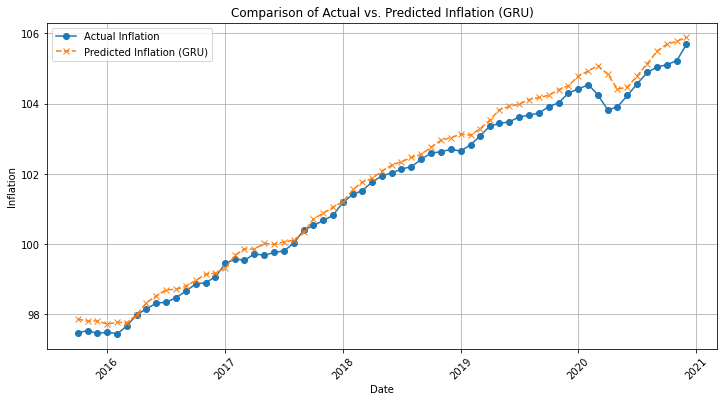

Root Mean Squared Error (RMSE): 0.328376


In [12]:
# Make Predictions on Val Set 
gru_model.eval()
predictions = []
actuals = []
dates = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        outputs = gru_model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# Concatenate batches into single arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform the normalized predictions and actual values back to the original scale
predictions_inv = scaler.inverse_transform(predictions)
actuals_inv = scaler.inverse_transform(actuals)

# Extract the dates corresponding to the validation predictions
val_dates = val_df.index[sequence_length:]

# Create a DataFrame for comparison
df_comparison = pd.DataFrame({
    "Date": val_dates,
    "Actual Inflation": actuals_inv.flatten(),
    "Predicted Inflation": predictions_inv.flatten()
})

# Display the first few rows of the comparison DataFrame
print(df_comparison.head())

# Plot the actual vs. predicted Inflation values
plt.figure(figsize=(12, 6))
plt.plot(df_comparison["Date"], df_comparison["Actual Inflation"], label='Actual Inflation', marker='o', linestyle='-')
plt.plot(df_comparison["Date"], df_comparison["Predicted Inflation"], label='Predicted Inflation (GRU)', marker='x', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.title("Comparison of Actual vs. Predicted Inflation (GRU)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# Compute RMSE for validation predictions
rmse = np.sqrt(mean_squared_error(actuals_inv, predictions_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")

